In [3]:
import pickle
import pandas as pd
#from DataLoader import *
from data_module import DataLoader
import math
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size'] = 16

In [5]:
# this data is from the NGSIM dataset, which provides the leader's trajectory
# f2l2 means follower and leader are automobile ("2" stands for automobile in NGSIM)
with open("real_data_lane3_f2l2.pickle", 'rb') as f:
    traj = pickle.load(f)

In [6]:
def simIDM(para, ini_state, traj_l, delta_t = 0.1):
    '''
    para: v0, T, s0, a, b
    '''
    v_f_sim = ini_state[1]
    x_f = ini_state[0]
    X_F_SIM = [x_f]
    V_F_SIM = [v_f_sim]
    A_F_SIM = []
    delta_v = traj_l[0,1] - ini_state[1]
    delta_s = traj_l[0,0] - ini_state[0]

    for i in range(1, len(traj_l)):
        root = math.sqrt(para[3] * para[4])
        temp = v_f_sim * para[1]-0.5 * v_f_sim * delta_v / root

        #if temp<0:
        #    temp = 0

        desired_s_n = para[2] + temp
        An = para[3] * (1 - (v_f_sim / para[0])**4 - (desired_s_n / delta_s)**2)
        #An = max(An, para[3])
        #if An < -10:
        #    An = -10
        v_f_sim_new = v_f_sim +  delta_t * An

        x_f_new = x_f + (v_f_sim_new + v_f_sim)/2*delta_t
        x_f = x_f_new
        v_f_sim = v_f_sim_new

        delta_v = traj_l[i,1] - v_f_sim_new
        delta_s = traj_l[i,0] - x_f
        X_F_SIM.append(x_f_new)
        V_F_SIM.append(v_f_sim)
        A_F_SIM.append(An)
    return X_F_SIM, V_F_SIM, A_F_SIM

In [7]:
"""para: v0, T, s0, a, b"""
para = [30, 1.5, 2, 0.73, 1.67]

In [8]:
para = {'v0': 30, 'T': 1.5, 's0': 2, 'a': 0.73, 'b': 1.67}

In [14]:
len(traj)

371

In [15]:
IDM_data = []
A_F_SIM = []
"""para: v0, T, s0, a, b"""
para = [30, 1.5, 2, 0.73, 1.67]
#para = [31.28339996,  1.65056612,  7.17992369,  1.22401703,  0.16626898] # para from 10 ga

            # here start with 1     # a mistake, literally 435
            #    |                       |
for idx in range(1,len(traj)):
    init_x_v_f = [traj[idx][0][0], traj[idx][0][1]]
    x_f_sim, v_f_sim, a_f_sim = simIDM(para, init_x_v_f,traj[idx][:,2:])
    x_f_sim = np.array(x_f_sim).reshape(-1,1)
    v_f_sim = np.array(v_f_sim).reshape(-1,1)
    a_f_sim = np.array(a_f_sim).reshape(-1,1)
    idm_data = np.hstack( [ x_f_sim[:-1], v_f_sim[:-1] ,  traj[idx][:-1,2:]])
    IDM_data.append(idm_data)
    A_F_SIM.append(a_f_sim)

In [16]:
IDM_data

[array([[ 15.3286968 ,  10.66799716,  37.60509624,  11.11117624],
        [ 16.39723776,  10.70282195,  38.72048136,  11.11270024],
        [ 17.46921986,  10.73682005,  39.83379384,  11.04137706],
        ...,
        [585.06758645,  18.28037325, 621.60738264,  18.18070555],
        [586.89626973,  18.29329228, 623.42411256,  18.17460955],
        [588.72621239,  18.30556099, 625.24154352,  18.17491435]]),
 array([[ 17.06124096,  13.00185013,  27.77008416,  13.56451078],
        [ 18.3544162 ,  12.86165472,  29.1265356 ,  13.56420598],
        [ 19.63480207,  12.74606267,  30.48295656,  13.56420598],
        ...,
        [599.8366533 ,  17.42971176, 634.41538344,  17.08525464],
        [601.57995082,  17.4362386 , 636.12269016,  17.15261543],
        [603.32398232,  17.4443914 , 637.84410912,  17.2449698 ]]),
 array([[ 16.69569432,  12.26728233,  42.913554  ,  14.28627699],
        [ 17.92552252,  12.32928176,  44.34818664,  14.39295696],
        [ 19.16157575,  12.39178265,  45.79220

In [17]:
data = {"idm_data": IDM_data,
       "para":{
           'v0':para[0],
           'T':para[1],
           's0':para[2],
           'a': para[3],
           'b': para[4]
       }}

In [ ]:
#### UNCOMMENT to save the data

#with open('idm_data_no_restriction.pickle', 'wb') as f:
#    pickle.dump(data, f)

In [20]:
sum_data = 0
for i in range(10):
    sum_data += len(IDM_data[i])
print(sum_data)

5427


In [22]:
REAL_data = []
for idx in range(1, len(traj)):
    REAL_data.append(traj[idx])

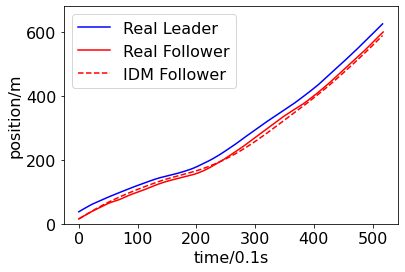

In [23]:
idx = 0

plt.plot(IDM_data[idx][:,2],'b')
plt.plot(REAL_data[idx][:,0], 'r')
plt.plot(IDM_data[idx][:,0], '--r' )
#plt.plot(REAL_data[idx][:,2],'b')
plt.xlabel('time/0.1s')
plt.ylabel('position/m')
plt.ylim([0,680])
plt.legend(['Real Leader', 'Real Follower', 'IDM Follower'])

In [27]:
def xvlf_to_feature(arr):
    #dx
    dx = arr[:,2] - arr[:,0]
    dx = dx.reshape(-1,1)
    dx = dx[:-1,:]
    
    #dv
    dv = arr[:,3] - arr[:,1]
    dv = dv.reshape(-1,1)
    dv = dv[:-1,:]
    
    #vf and a
    vf = arr[:,1]
    a = np.diff(vf)*10
    vf = vf.reshape(-1,1)
    vf = vf[:-1,:]
    a = a.reshape(-1,1)
    a.shape

    return np.hstack([dx, dv, vf, a])

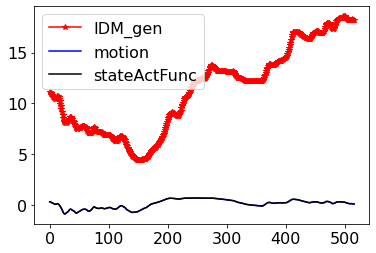

In [28]:
# check if the acc is consistent
# CONSISTENT!!!
# =================================
test = IDM_data[0]
a_in_IDM_gen = test[:-1,-1]
a_by_motion = np.diff(test[:,1])*10
para = {'v0': 30, 'T': 1.5, 's0': 2, 'a': 0.73, 'b': 1.67}
# a_in_IDM_stateActFunc
def feature_to_a(x, para):# x = [dx, dv, v]
    dx = x[0]
    dv = x[1]
    v = x[2]
    s0 = para['s0']; v0 = para['v0']; T = para['T']
    a = para['a']; b = para['b']
    # idm equation
    s_star = s0 + T*v - v*dv/2/np.math.sqrt(a*b)
    acc = a*(1-np.math.pow(v/v0, 4) - np.math.pow(s_star/dx,2))
    return acc

feature = xvlf_to_feature(test)
a_in_IDM_stateActFunc = [feature_to_a(x, para) for x in feature]

plt.plot(a_in_IDM_gen,'-*r')
plt.plot(a_by_motion, 'b')
plt.plot(a_in_IDM_stateActFunc, 'k')
#plt.ylim([-10,10])
plt.legend(['IDM_gen', 'motion', 'stateActFunc'])

In [29]:
A_F_SIM_in_one = [np.array(a_f).flatten() for a_f in A_F_SIM]

In [30]:
A_F_SIM_in_one = np.hstack(A_F_SIM_in_one).flatten()
A_F_SIM_in_one.shape

(218262,)

(array([1.00000e+00, 0.00000e+00, 4.00000e+00, 1.50000e+01, 8.90000e+01,
        4.94000e+02, 4.65300e+03, 2.52350e+04, 8.57820e+04, 1.01989e+05]),
 array([-5.01850828, -4.44365936, -3.86881044, -3.29396153, -2.71911261,
        -2.14426369, -1.56941477, -0.99456586, -0.41971694,  0.15513198,
         0.72998089]),
 <BarContainer object of 10 artists>)

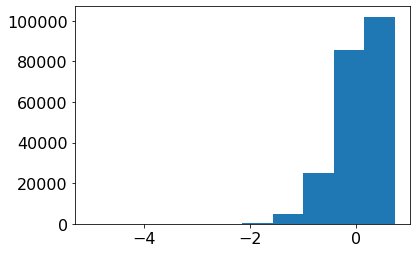

In [31]:
plt.hist(A_F_SIM_in_one)

In [32]:
IDM_data[0]

array([[ 15.3286968 ,  10.66799716,  37.60509624,  11.11117624],
       [ 16.39723776,  10.70282195,  38.72048136,  11.11270024],
       [ 17.46921986,  10.73682005,  39.83379384,  11.04137706],
       ...,
       [585.06758645,  18.28037325, 621.60738264,  18.18070555],
       [586.89626973,  18.29329228, 623.42411256,  18.17460955],
       [588.72621239,  18.30556099, 625.24154352,  18.17491435]])

In [33]:
vf_IN_ONE = np.vstack(IDM_data)[:,1] 

(array([13741., 15839., 28132., 34171., 45885., 42829., 21057., 11497.,
         4290.,   821.]),
 array([-0.06033941,  2.04471966,  4.14977873,  6.2548378 ,  8.35989687,
        10.46495594, 12.57001501, 14.67507408, 16.78013315, 18.88519222,
        20.99025129]),
 <BarContainer object of 10 artists>)

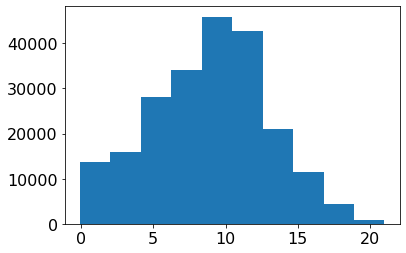

In [34]:
plt.hist(vf_IN_ONE)